<center><h1><b><span style="color:blue">Histogramming & visualisation</span></b></h1></center>

&nbsp;<br>
### **Quick intro to the following packages**
- `boost-histogram` - fast and flexible multi-dimensional histograms and profiles.
- `Hist` - analyst-friendly front-end for boost-histogram.
- `mplhep` - HEP domain-specific add-ons to matplotlib.

**Note:** the fact that there is some overlap in some of the functionality these packages provide may be overwhelming at first - no different from the fact that very many Python libraries exist for visualisation out there, actually.
Remember, the development of these packages are largely driven by the community (needs and feedback). See this as a motivation to contribute towards the most useful and best features.

&nbsp;<br><center><img src="images/logo_boost-histogram.png" alt="boost-histogram package logo" style="width: 150px;"/></center>

<center><h2><b><span style="color:green">Fast and flexible multi-dimensional histograms and profiles</span></b></h2></center>

* Python bindings for the C++14 Boost.Histogram library.
* No external dependency.
* Very fast and feature-rich.
* Multi-dimensional histograms and profiles.
* Supports weighted and unweighted data.
* And much much more, see the [docs](https://boost-histogram.readthedocs.io/).

<div class="alert alert-info">

<b>Acknowledgements</b>

This mini-tutorial is largely based on material by Henry Schreiner (Princeton University), with minor modifications.
</div>

### **1. Basic 1D histogram**

In [1]:
import boost_histogram as bh

import numpy as np
import matplotlib.pyplot as plt

Let's generate some data and create a histogram:

In [2]:
data1 = np.random.normal(3.5, 2.5, size=1_000_000)

h1 = bh.Histogram(bh.axis.Regular(40, -2, 10))

In [3]:
h1.fill(data1)

Histogram(Regular(40, -2, 10), storage=Double()) # Sum: 981624.0 (1000000.0 with flow)

Let's explicitly check to see how many entries are in the histogram:

In [4]:
h1.sum()

981624.0

What happened to the missing items? They are in the underflow and overflow bins ;-):

In [5]:
h1.sum(flow=True)

1000000.0

As is ROOT, overflow bins are on by default. We can turn them off, but they enable some powerful things such as projections.

Make sure things visually look OK:

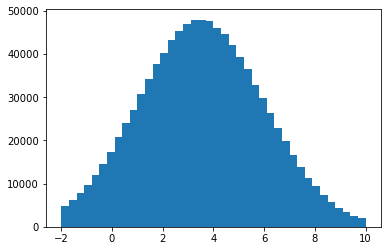

In [6]:
plt.bar(h1.axes[0].centers, h1, width=h1.axes[0].widths);

From now on, let's be lazy with a helper function for plotting:

In [7]:
plothist = lambda h: plt.bar(h.axes[0].centers, h, width=h.axes[0].widths);

### **2. Drop-in replacement for NumPy**

In [8]:
bins2, edges2 = bh.numpy.histogram(data1, bins=10)
bins2, edges2

(array([    75,   2236,  30091, 160503, 351658, 316901, 119178,  18093,
          1236,     29], dtype=uint64),
 array([-8.42991355, -5.98791593, -3.54591832, -1.1039207 ,  1.33807691,
         3.78007453,  6.22207215,  8.66406976, 11.10606738, 13.54806499,
        15.99006261]))

### **3. "Extra dimensions"**
The same API works for multiple dimensions. This is an area where the library shines particularly well.

In [9]:
h2 = bh.Histogram(
    bh.axis.Regular(150, -1.5, 1.5),
    bh.axis.Regular(100, -1, 1)
)

h2

Histogram(
  Regular(150, -1.5, 1.5),
  Regular(100, -1, 1),
  storage=Double())

In [10]:
def make_2D_data(*, mean=(0,0), widths=(1,1), size=1_000_000):
    cov = np.asarray(widths) * np.eye(2)
    return np.random.multivariate_normal(mean, cov, size=size).T

In [11]:
data3x = make_2D_data(mean=[-.75, .5], widths=[.2, 0.02])
data3y = make_2D_data(mean=[.75, .5], widths=[.2, 0.02])

From here on we will be using `.reset()` before a `.fill()`, just to make sure each cell in the notebook can be rerun.

In [12]:
h2.reset()
h2.fill(*data3x)
h2.fill(*data3y)

Histogram(
  Regular(150, -1.5, 1.5),
  Regular(100, -1, 1),
  storage=Double()) # Sum: 1905683.0 (2000000.0 with flow)

Again, let's make plotting a little function:

In [13]:
def plothist2d(h):
    X, Y = h.axes.edges
    X, Y = np.broadcast_arrays(X, Y)

    return plt.pcolormesh(X, Y, h)

> The above code is the same as doing:
> 
> ```python
X, Y = np.meshgrid(*(a.edges for a in h.axes, indexing='ij')
```

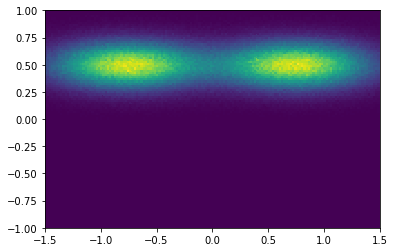

In [14]:
plothist2d(h2);

Let's try a 3D histogram

In [15]:
data3d = [np.random.normal(size=1_000_000) for _ in range(3)]

h3d = bh.Histogram(
    bh.axis.Regular(150, -5, 5),
    bh.axis.Regular(100, -5, 5),
    bh.axis.Regular(100, -5, 5)
)

h3d.fill(*data3d)

Histogram(
  Regular(150, -5, 5),
  Regular(100, -5, 5),
  Regular(100, -5, 5),
  storage=Double()) # Sum: 999999.0 (1000000.0 with flow)

Projection of the first two axes:

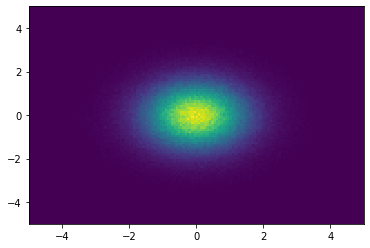

In [16]:
plothist2d(h3d.project(0,1));

### **4. Unified Histogram Indexing**

Let's explore the boost-histogram UHI syntax. We will reuse the previous 2D histogram from part 3:

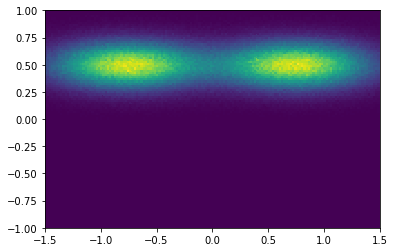

In [17]:
plothist2d(h2);

I can see that I want y from 0.25 to 0.75, in data coordinates:

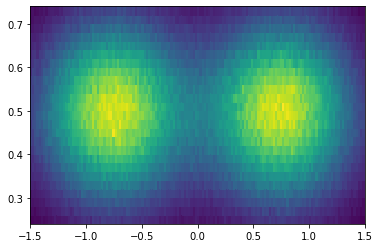

In [18]:
plothist2d(h2[:, bh.loc(.25):bh.loc(.75)]);

What's the contents of a bin?

In [19]:
h2[100,87]

214.0

How about in data coordinates?

In [20]:
h2[bh.loc(.5), bh.loc(.75)]

214.0

> Note: to get the coordinates manually:
> 
> ```python
h2.axes[0].index(.5) == 100
h2.axes[1].index(.75) == 87
```

Let's look at one part and rebin:

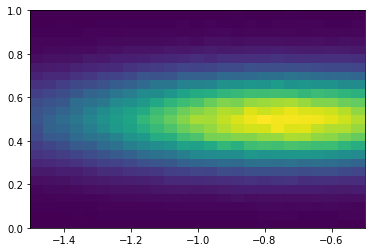

In [21]:
plothist2d(h2[:50:bh.rebin(2), 50::bh.rebin(2)]);

What is the value at `(-.75, .5)`?

In [22]:
h2[bh.loc(-.75), bh.loc(.5)]

970.0

### **5. Fancier axis types - a circular axis example**

In [23]:
h = bh.Histogram(bh.axis.Regular(30, 0, 2*np.pi, circular=True))
h.fill(np.random.uniform(0, np.pi*4, size=300))

Histogram(Regular(30, 0, 6.28319, circular=True), storage=Double()) # Sum: 300.0

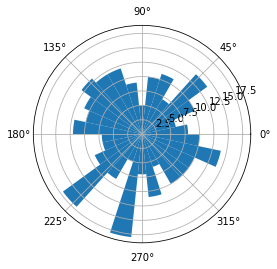

In [24]:
ax = plt.subplot(111, polar=True)

plothist = lambda h: plt.bar(h.axes[0].centers, h, width=h.axes[0].widths)
plothist(h);

&nbsp;<br><center><img src="images/logo_mplhep.png" alt="mplhep package logo" style="width:150px;"/></center>

<center><h2><b><span style="color:green">HEP domain-specific add-ons to matplotlib</span></b></h2></center>

### Package motivation 

- Collect a set of helpers for `matplotlib` to more easily produce plots typically needed in HEP.
- Collect styles that are compatible with current collaboration requirements (ROOT-like plots for CMS, ATLAS, LHCb, ALICE).

In [25]:
import mplhep

import numpy as np
import matplotlib.pyplot as plt

### **1. Some basics**

Plotting of 1D histograms made easy for "standard" and commonly used looks in HEP:

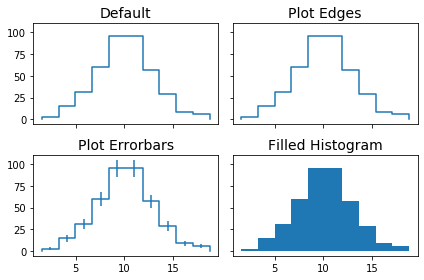

In [26]:
h, bins = np.histogram(np.random.normal(10,3,400), bins=10)

f, axs = plt.subplots(2,2, sharex=True, sharey=True)
axs = axs.flatten()

axs[0].set_title("Default", fontsize=14)
mplhep.histplot(h, bins, ax=axs[0])

axs[1].set_title("Plot Edges", fontsize=14)
mplhep.histplot(h, bins, edges=True, ax=axs[1])

axs[2].set_title("Plot Errorbars", fontsize=14)
mplhep.histplot(h, bins, yerr=np.sqrt(h), ax=axs[2])

axs[3].set_title("Filled Histogram", fontsize=14)
mplhep.histplot(h, bins, histtype='fill', ax=axs[3])

plt.tight_layout()
plt.show()

It is just as easy to overlay 2, or more, 1D histograms:

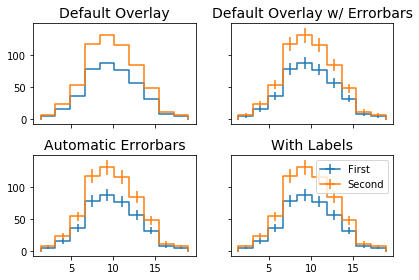

In [27]:
h, bins = np.histogram(np.random.normal(10,3,400), bins = 10)

f, axs = plt.subplots(2,2, sharex=True, sharey=True)
axs = axs.flatten()

axs[0].set_title("Default Overlay", fontsize=14)
mplhep.histplot([h, 1.5*h], bins, ax=axs[0])

axs[1].set_title("Default Overlay w/ Errorbars", fontsize=14)
mplhep.histplot([h, 1.5*h], bins, yerr=[np.sqrt(h), np.sqrt(1.5*h)], ax=axs[1])


axs[2].set_title("Automatic Errorbars", fontsize=14)
mplhep.histplot([h, 1.5*h], bins, yerr=True, ax=axs[2])

axs[3].set_title("With Labels", fontsize=14)
mplhep.histplot([h, 1.5*h], bins, yerr=True, ax=axs[3], label=["First", "Second"])

axs[3].legend(fontsize=10)

plt.tight_layout()
plt.show()

In other situations one rather needs to stack a series of 1D histograms. Here is how this can be done:

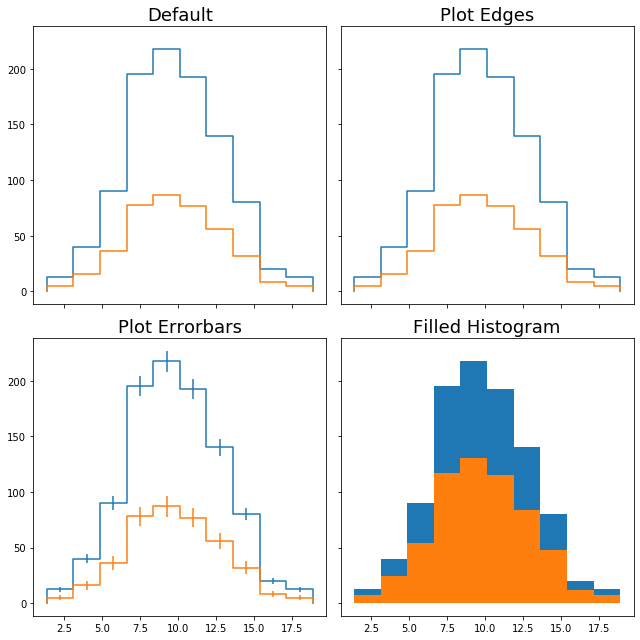

In [28]:
f, axs = plt.subplots(2,2, sharex=True, sharey=True, figsize=(9, 9))
axs = axs.flatten()

axs[0].set_title("Default", fontsize=18)
mplhep.histplot([h, 1.5*h], bins, stack=True, ax=axs[0])

axs[1].set_title("Plot Edges", fontsize=18)
mplhep.histplot([h, 1.5*h], bins, edges=True, stack=True,ax=axs[1])

axs[2].set_title("Plot Errorbars", fontsize=18)
mplhep.histplot([h, 1.5*h], bins, yerr=np.sqrt(h), stack=True, ax=axs[2])

axs[3].set_title("Filled Histogram", fontsize=18)
mplhep.histplot([1.5*h, h], bins, histtype='fill', stack=True, ax=axs[3])

plt.tight_layout()
plt.show()

### **2. Fancier plots**

Likewise, `mplhep` provides a simple way to plot 2D histograms.

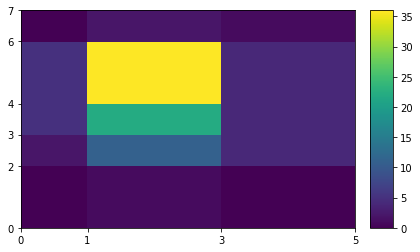

In [29]:
fig, ax = plt.subplots()

xedges = [0, 1, 3, 5]
yedges = [0, 2, 3, 4, 6,7]
x = np.random.normal(2, 1, 100)
y = np.random.normal(4, 1, 100)

mplhep.hist2dplot(*np.histogram2d(x, y, bins=(xedges, yedges)));

There's no trouble if starting from a `boost-histogram` histogram - just convert it on-the-fly:

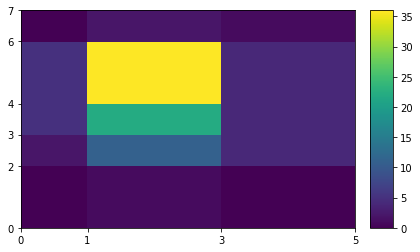

In [30]:
h2 = bh.Histogram(
    bh.axis.Variable(xedges),
    bh.axis.Variable(yedges)
)
h2.fill(x,y)

mplhep.hist2dplot(*h2.to_numpy());

### **3. Styling**

As said above, several styles are predefined. Here is a simple example:

findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.
findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.
findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.


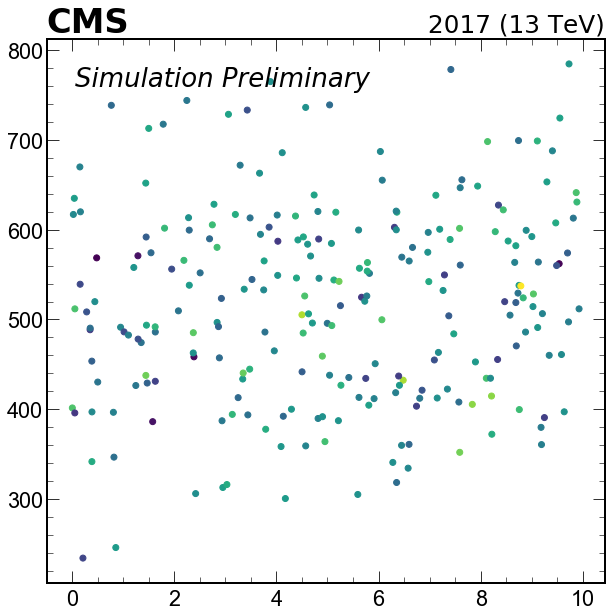

In [31]:
x = np.random.uniform(0, 10, 240)
y = np.random.normal(512, 112, 240)
z = np.random.normal(0.5, 0.1, 240)

plt.style.use([mplhep.style.ROOT, mplhep.style.firamath])  # styles can be chained

f, ax = plt.subplots()
ax.scatter(x,y, c=z, label='XSX')
mplhep.cms.label(loc=3)

plt.show();

&nbsp;<br>
<center><h2><b><span style="color:green">Hist</span></b></h2></center>

<center><h2><b><span style="color:green">Analyst friendly front-end for boost-histogram</span></b></h2></center>

- `Hist` is a powerful, friendly and analysis-focused histogramming tool based on `boost-histogram`.
- It provides some cool shortcuts for histogram creation, plotting tools, and new ideas.

Let's explore the library a bit with some examples. See also the [GitHub repository](https://github.com/scikit-hep/hist) for full documentation.

In [32]:
import hist
from hist import Hist
import numpy as np

### **1. Cool representations in notebooks**

In [33]:
Hist.new.Reg(50, 1, 2).Double().fill(np.random.normal(1.5, 0.3, 10_000))

Hist(Regular(50, 1, 2, label='Axis 0'), storage=Double()) # Sum: 8984.0 (10000.0 with flow)

In [34]:
h2 = Hist.new.Reg(50, 0, 2, name='My preferred x-axis title').Reg(50, 10, 20).Double().fill(
    np.random.normal(1, 0.5, 10_000), np.random.normal(15, 3, 10_000)
)
h2

Hist(
  Regular(50, 0, 2, name='My preferred x-axis title', label='My preferred x-axis title'),
  Regular(50, 10, 20, label='Axis 1'),
  storage=Double()) # Sum: 8638.0 (10000.0 with flow)

In [35]:
Hist.new.Reg(50, 0, 2).Reg(50, 10, 20).Reg(2, 3, 4).Double()

Hist(
  Regular(50, 0, 2, label='Axis 0'),
  Regular(50, 10, 20, label='Axis 1'),
  Regular(2, 3, 4, label='Axis 2'),
  storage=Double())

Based on `boost-histogram`’s Axis, `Hist` supports six types of axis (Regular, Boolean, Variable, Integer, IntCategory and StrCategory), with additional names and labels.

You can checkout `hist.axis` or use the shortcut definitions instead:

In [36]:
# Add the axes using the shortcut method
h = (
    Hist.new.Reg(10, -5, 5, overflow=False, underflow=False, name="A")
    .Bool(name="B")
    .Var(range(10), name="C")
    .Int(-5, 5, overflow=False, underflow=False, name="D")
    .IntCat(range(10), name="E")
    .StrCat(["T", "F"], name="F")
    .Double()
)
h

Hist(
  Regular(10, -5, 5, underflow=False, overflow=False, name='A', label='A'),
  Boolean(, name='B', label='B'),
  Variable([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  Integer(-5, 5, underflow=False, overflow=False),
  IntCategory([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  StrCategory(['T', 'F']),
  storage=Double())

### **2. Handy plotting functions**

In [37]:
data1 = np.random.normal(3.5, 2.5, size=1_000_000)

h1 = Hist(hist.axis.Regular(40, -2, 10, name="Variable x"), storage=hist.storage.Double())

h1.fill(data1)

Hist(Regular(40, -2, 10, name='Variable x', label='Variable x'), storage=Double()) # Sum: 981257.0 (1000000.0 with flow)

The histogram "knows how to plot itself" - very handy for quick checks:

[FillArtists(fill_between=<matplotlib.collections.PolyCollection object at 0x0000015EDF5EDE08>)]

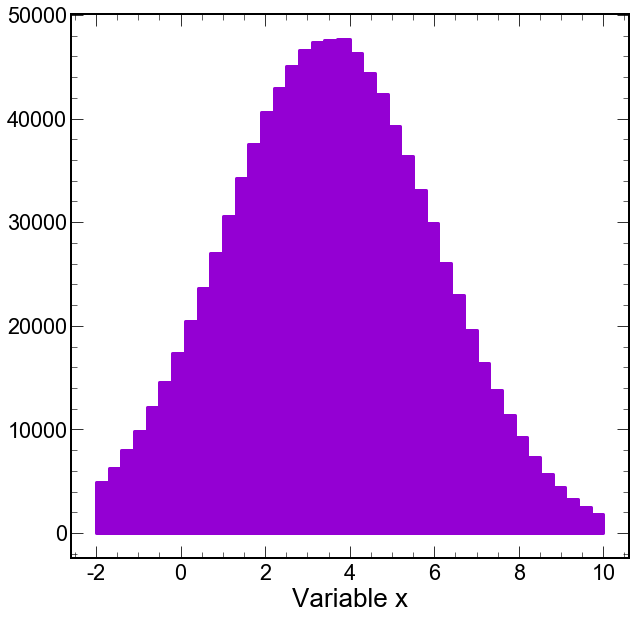

In [38]:
h1.plot(color="darkviolet", lw=3, histtype='fill')

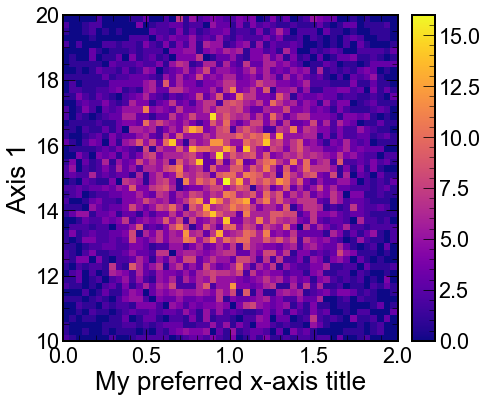

In [39]:
import matplotlib.pyplot as plt
# plot2d
fig, ax = plt.subplots(figsize=(6, 6))

h2.plot2d(ax=ax, cmap="plasma")
plt.show()

This being said, `Hist` talks well with the HEP plotting library `mplhep`:

In [40]:
h = bh.Histogram(
bh.axis.Regular(2, 0, 1, metadata="x"),
bh.axis.Regular(4, 0, 1, metadata="y"))
h.fill(
[.2, .4, .3],
[.3, .5, .2])
h

Histogram(
  Regular(2, 0, 1),
  Regular(4, 0, 1),
  storage=Double()) # Sum: 3.0

ColormeshArtist(pcolormesh=<matplotlib.collections.QuadMesh object at 0x0000015ED7EE0048>)

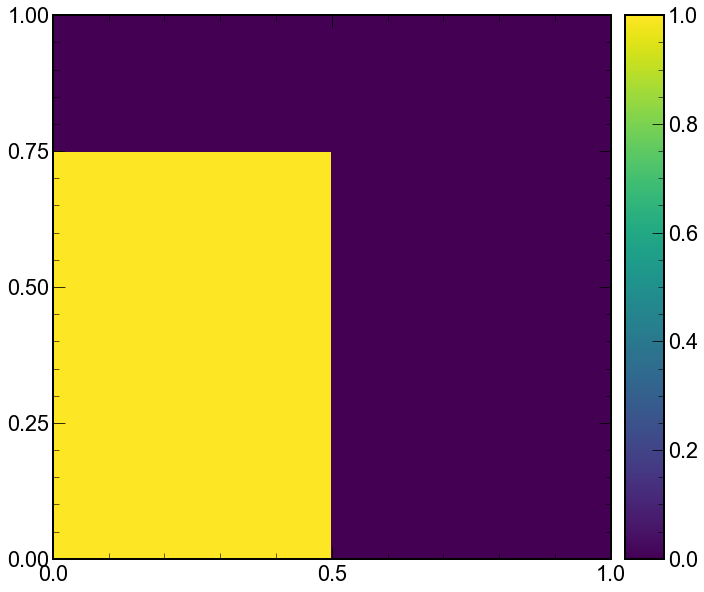

In [41]:
mplhep.hist2dplot(h)

Did we not say "handy plotting functions" and a "powerful, friendly and analysis-focused histogramming tool"? Check this out:

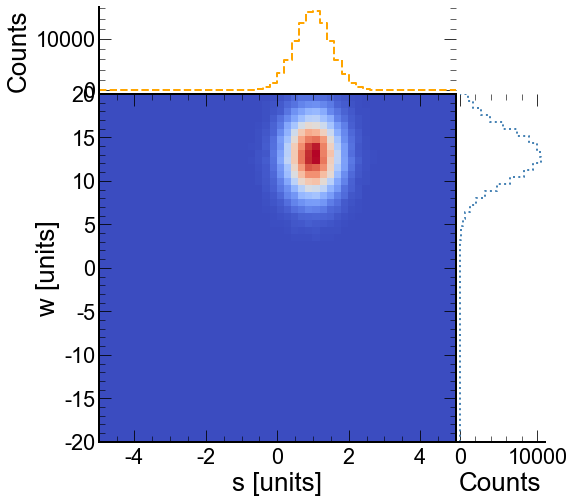

In [42]:
h = Hist(
    hist.axis.Regular(50, -5, 5, name="S", label="s [units]", flow=False),
    hist.axis.Regular(50, -5, 5, name="W", label="w [units]", flow=False),
)

import numpy as np

s_data = np.random.normal(size=10_000) + np.ones(10_000)
w_data = np.random.normal(size=10_000)
s_data = np.random.normal(1, 0.5, 100_000)
w_data = np.random.normal(13, 3, 100_000)

# normal fill
#h.fill(s_data, w_data)
#h = Hist.new.Reg(50, 0, 2, name="S", label="s [units]", flow=False).Reg(50, 10, 20, name="W", label="s [units]", flow=False).Double().fill(
#    np.random.normal(1, 0.5, 100_000), np.random.normal(15, 0.5, 100_000)
#)
h = Hist.new.Reg(50, -5, 5, name="S", label="s [units]", flow=False).Reg(50, -20, 20, name="W", label="w [units]", flow=False).Double().fill(
    s_data, w_data)

# plot2d_full
plt.figure(figsize=(8, 8))

h.plot2d_full(
    main_cmap="coolwarm",
    top_ls="--",
    top_color="orange",
    top_lw=2,
    side_ls=":",
    side_lw=2,
    side_color="steelblue",
)

plt.show()

Now we really are mixing all libraries - checking the projections with `mplhep`:

[StepArtists(step=<matplotlib.lines.Line2D object at 0x0000015ED84A07C8>, errorbar=None, legend_artist=None)]

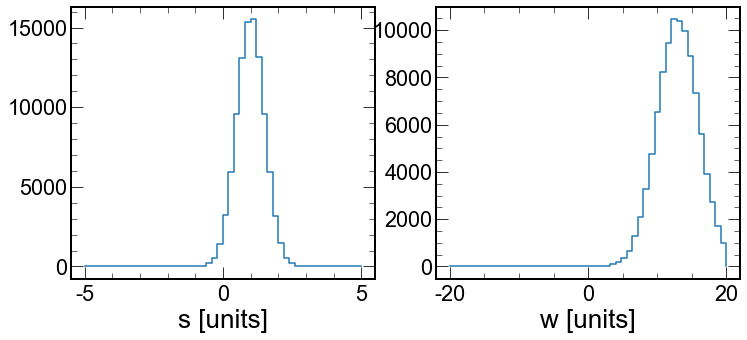

In [43]:
import mplhep

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

mplhep.histplot(h.project("S"), ax=axs[0])
mplhep.histplot(h.project("W"), ax=axs[1])

Pull plots are very commonly used in HEP, e.g. to make sure that a toy study produces unbiased results and returns adequate uncertainties.
`Hist` hence provides a powerful and flexible method for pull studies, called `.plot_pull()`. The method can be passed in a Callable object to be used to fit the plot.

For the sake of argument, let's define a Gaussian function (following the `Hist` documentation):

In [44]:
# The unumpy module of the uncertainties package deals with uncertainties in arrays
from uncertainties import unumpy as unp

def pdf(x, a=1 / np.sqrt(2 * np.pi), x0=0, sigma=1, offset=0):
    exp = unp.exp if a.dtype == np.dtype("O") else np.exp  #  'O' for a Python object
    return a * exp(-((x - x0) ** 2) / (2 * sigma ** 2)) + offset

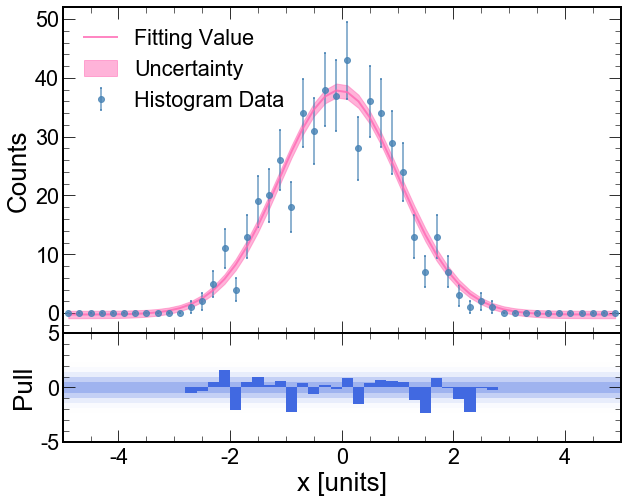

In [47]:
fig = plt.figure(figsize=(10, 8))

# Fill a histogram with 500 entries
hh = hist.Hist(
    hist.axis.Regular(
        50, -5, 5, name="X", label="x [units]", underflow=False, overflow=False
    )
).fill(np.random.normal(size=500))

# Plot the histogram (data points) together with the fitted curve, and the pull plot
ax, pull_ax = hh.plot_pull(
    pdf,
    eb_ecolor="steelblue",
    eb_mfc="steelblue",
    eb_mec="steelblue",
    eb_fmt="o",
    eb_ms=6,
    eb_capsize=1,
    eb_capthick=2,
    eb_alpha=0.8,
    fp_c="hotpink",
    fp_ls="-",
    fp_lw=2,
    fp_alpha=0.8,
    bar_fc="royalblue",
    pp_num=5,
    pp_fc="royalblue",
    pp_alpha=0.5,
    pp_ec=None,
    ub_alpha=0.5,
)

pull_ax.set_ylim(-5, 5)

#plt.savefig('pull.png')
#plt.close(fig)
plt.show()